In [1]:
import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)
import pyvisa
import joblib


In [2]:
data = joblib.load("data_waveform/averaged_pulse_1pe_preamp_v4_40.7V.joblib")

time_series = data["time_series_ns"]
avg_pulse = data["averaged_pulse_1pe_volt"]

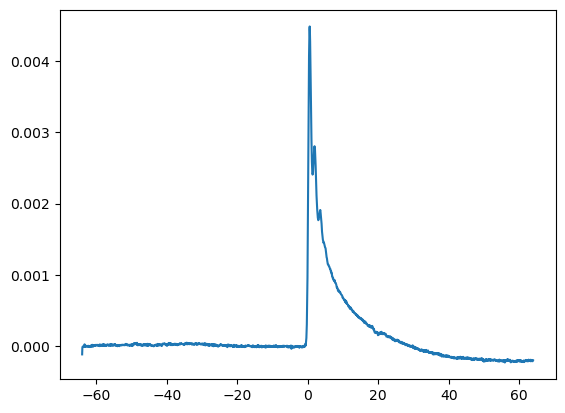

In [3]:
plot(time_series,avg_pulse)

In [4]:
len(avg_pulse)

2048

/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:61: RuntimeWarning: divide by zero encountered in true_divide
  pulse/=max(pulse)
/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:61: RuntimeWarning: invalid value encountered in true_divide
  pulse/=max(pulse)
/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:56: RuntimeWarning: overflow encountered in exp
  pulse = (A1     *     (np.exp(-times[mask] / tau_f1))


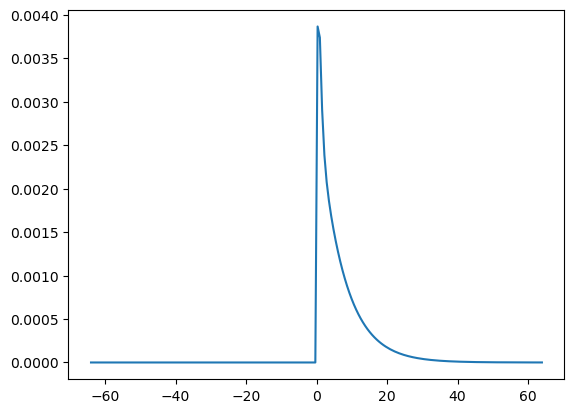

In [5]:
x = time_series
y = avg_pulse
popt, pconv, info, f = hp.fit_curve(hp.Pulse2,data['time_series_ns'],data['averaged_pulse_1pe_volt'],p0=[2,4,10,0.001,0.001,0,0.008])

# Example 1: generate a pulse repetitively 

In [6]:
min(x)

-64.01595593

2047
2047
<class 'numpy.ndarray'>


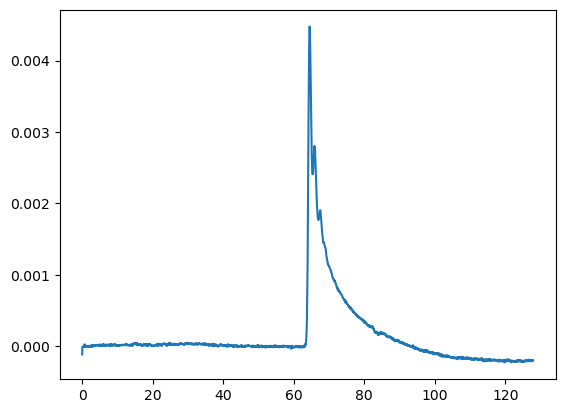

In [7]:
samples_per_ns = 16 # 2.5 Gsps --> 2.5 samples per ns
samples_per_s = samples_per_ns*1e9
ch=1

wave_1eh = scipy.signal.resample(y,int(16*(max(x)-min(x))))
print(int(16*(max(x)-min(x))))
time_series = np.arange(int(16*(max(x)-min(x))))/16
print(len(time_series))
plot(time_series,wave_1eh)
print(type(wave_1eh))

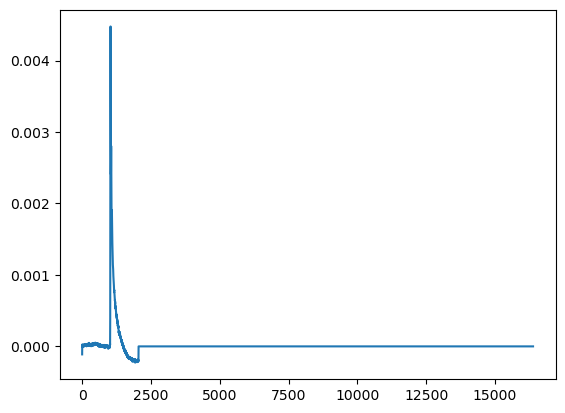

In [8]:
waveform_length = 16384
wave_1eh = np.pad(wave_1eh,(0,waveform_length-len(time_series)),mode='constant')
time_series = (np.arange(waveform_length)-10)/samples_per_ns
plot(wave_1eh)

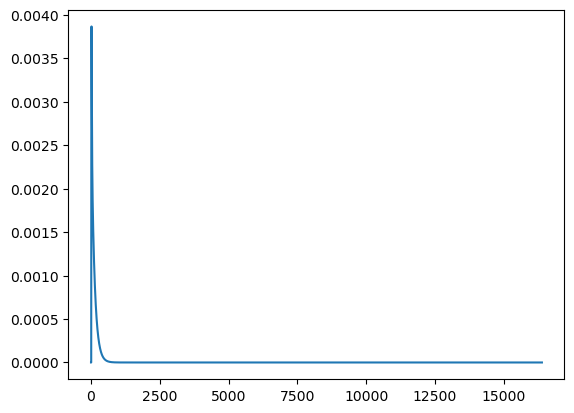

In [9]:
waveform_length = 16384
samples_per_ns = 16 # 2.5 Gsps --> 2.5 samples per ns
samples_per_s = samples_per_ns*1e9
waveform_duration = waveform_length/samples_per_ns
ch=1

time_series = (np.arange(waveform_length)-10)/samples_per_ns
# time_series = (np.arange(waveform_length)-waveform_length//2)/samples_per_ns
waveform_1eh = hp.Pulse2(time_series, *popt)
# waveform_14bit = hp.float_to_ADU(waveform, bits=14)    
plot(waveform_1eh)


## Examples

In [11]:
# Signal size and trigger
n_expected = 36 # number of eh expected
n_threshold = 1 # threshold [eh]

# WLS fiber parameter
WLS_t_decay = 2 # [ns]
# No laser parameter
LASER_time_spread = 0
#Plastic Scintillator Parameter
psdec = 3.0


# Run parameters
N_EXPERIMENTS = 4000
N_PLOTS = N_EXPERIMENTS
SEED = 1


noise_temp = 0

results_trigger_time, results_pulses, _ = vs.mc_exp_decay_withps(n_expected, n_threshold, WLS_t_decay, psdec, LASER_time_spread,
                                                       N_EXPERIMENTS =N_EXPERIMENTS, N_PLOTS=N_PLOTS, SEED=SEED,
                                                       PULSE=waveform_1eh, Fs=samples_per_ns, noise_voltage_density=noise_temp)

100%|██████████| 4000/4000 [00:01<00:00, 2418.07it/s]


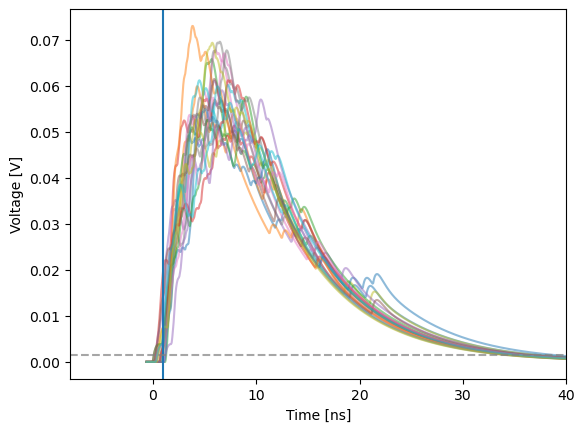

In [42]:
trigger_threshold = 0.0015*1


for i in range(20):
    plot(time_series, results_pulses[i],alpha=0.5)
    # plot(time_series, np.roll(results_pulses[i],-results_trigger_time[i]+8192),alpha=0.3)
xlim(-8,40)
xlabel("Time [ns]")
ylabel("Voltage [V]")
axvline(1)
axhline(trigger_threshold, color="grey", linestyle="--", alpha=0.7)
show()

In [44]:
trigger_times = []
trigger_slope = []
for pulse in results_pulses:
    trigpt = int(np.argmax(pulse>trigger_threshold))
    trigger_times.append(time_series[trigpt])
    trigger_slope.append((pulse[trigpt+1]-pulse[trigpt])/(time_series[trigpt+1]-time_series[trigpt])*1000)
    # trigger_slope.append((pulse[trigpt+1]-pulse[trigpt])/(time_series[trigpt+1]-time_series[trigpt])*1000)

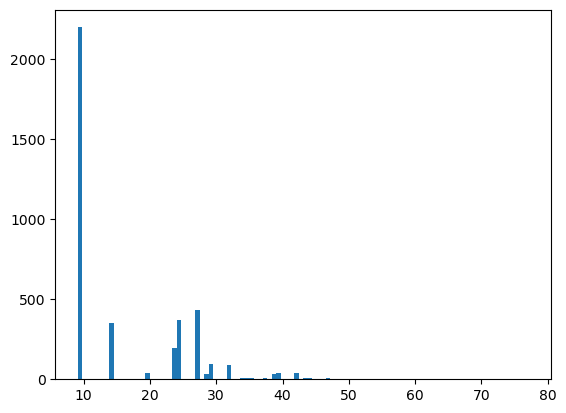

In [45]:
hist(trigger_slope,bins=100);

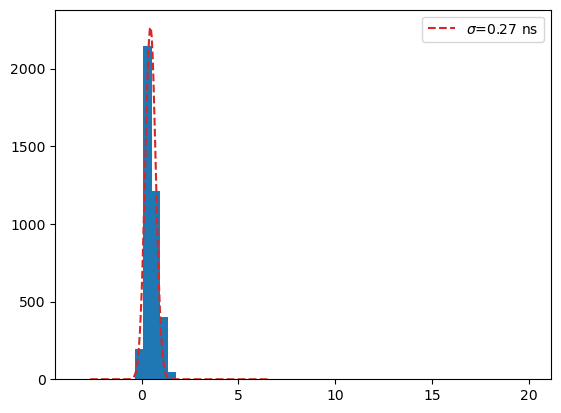

In [46]:
h = hist(trigger_times,bins=55, range=(-3.3,20));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--", fit_range=(-3,7));
legend()

In [47]:
amp_1eh_raw = np.max(waveform_1eh)*5/3
amp_1eh_at_asic = amp_1eh_raw*27/49
amp_1eh_at_disc = amp_1eh_at_asic*100
threshold = 0.15*20/63
threshold_eh = threshold/amp_1eh_at_disc
print(threshold_eh)

0.1340597737608661


In [48]:

reload(vs)

<module 'helper_visa' from '/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_visa.py'>

In [120]:
# Signal size and trigger
n_expected = 8 # number of eh expected
n_threshold = 0 # threshold [eh]

# WLS fiber parameter
WLS_t_decay = 2 # [ns]
# Laser parameter
LASER_time_spread = 0
#Plastic Scintillator parameter
psdec = 6.5

# Run parameters
N_EXPERIMENTS = 2000
N_PLOTS = N_EXPERIMENTS
SEED = 1

results_trigger_time, results_pulses, _ = vs.mc_exp_decay_withps(n_expected, n_threshold, WLS_t_decay, psdec, LASER_time_spread, N_EXPERIMENTS =N_EXPERIMENTS, N_PLOTS=N_PLOTS, SEED=SEED, PULSE=wave_1eh, Fs=samples_per_ns, noise_voltage_density=noise_voltage_density)

100%|██████████| 2000/2000 [00:00<00:00, 9637.44it/s]


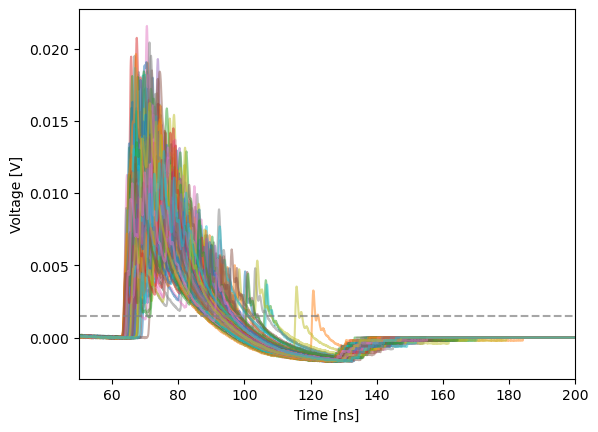

In [123]:
for i in range(200):
    plot(time_series, results_pulses[i],alpha=0.5)
    # plot(time_series, np.roll(results_pulses[i],-results_trigger_time[i]+8192),alpha=0.3)
xlim(50,200)
xlabel("Time [ns]")
ylabel("Voltage [V]")
axhline(trigger_threshold, color="grey", linestyle="--", alpha=0.7)
show()



trigger_times = []
for pulse in results_pulses:
    trigger_times.append(time_series[np.argmax(pulse>trigger_threshold)])

/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:135: RuntimeWarning: invalid value encountered in double_scalars
  mean = np.sum(xdata*ydata)/np.sum(ydata)
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


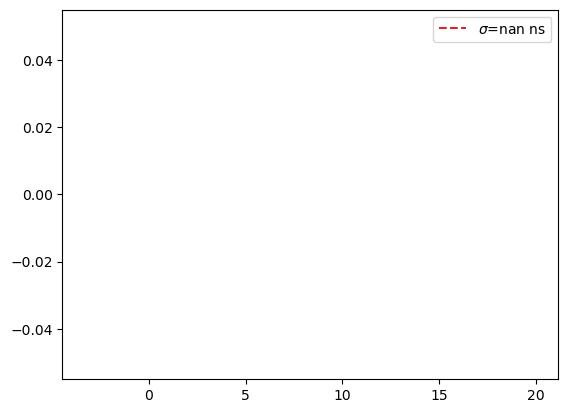

In [124]:
h = hist(trigger_times,bins=55, range=(-3.3,20));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--", fit_range=(-3,7));
legend()

In [138]:
amps = np.array(amps)
print(len(amps[amps>0.015]))

635
